In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Standard MM1 Queue Simulator Class

In [98]:
class NonStationaryMM1:
    def __init__(self, arrival_rate_func, service_rate_func, T_end, 
                 initial_queue_length=0, max_queue_length=None, 
                 time_step=0.1, collect_waiting_times=True, max_departures=115000):
        """
         Non-stationary M/M/1 queue simulation
        
        Parameters:
        arrival_rate_func (callable): Function λ(t) returning arrival rate at time t
        service_rate_func (callable): Function μ(t) returning service rate at time t
        T_end (float): End time for simulation
        initial_queue_length (int): Starting number of vehicles in queue
        max_queue_length (int): Maximum allowed queue length (None for unlimited)
        time_step (float): Time resolution for statistics collection
        collect_waiting_times (bool): Whether to collect individual waiting times
        max_departures (int): Maximum number of departures before stopping
        """
        self.lambda_t = arrival_rate_func
        self.mu_t = service_rate_func
        self.T_end = T_end
        self.max_queue_length = max_queue_length
        self.time_step = time_step
        self.max_departures = max_departures
        
        # State variables
        self.current_time = 0.0
        self.queue_length = initial_queue_length
        self.next_arrival_time = self.generate_next_arrival_time(0)
        self.next_departure_time = float('inf')
        
        # Enhanced statistics
        self.queue_length_history = []
        self.time_history = []
        self.waiting_times = [] if collect_waiting_times else None
        self.arrival_times = {}  # Dictionary to track arrival times of each customer
        self.customer_id = 0     # Unique ID for each customer
        
        # Performance metrics
        self.total_arrivals = 0
        self.total_departures = 0
        self.total_waiting_time = 0
        self.rejected_arrivals = 0  # Count of arrivals rejected due to max queue length

    def generate_next_arrival_time(self, current_time):
        """
        Generate time until next arrival using non-homogeneous Poisson process
        """
        U = np.random.random()
        dt = -np.log(U) / self.lambda_t(current_time)
        return current_time + dt

    def generate_service_time(self, current_time):
        """
        Generate service time using current service rate
        """
        U = np.random.random()
        return -np.log(U) / self.mu_t(current_time)
        
    def step(self):
        """
        Enhanced step function with more statistics collection
        """
        # Record current state
        self.queue_length_history.append(self.queue_length)
        self.time_history.append(self.current_time)
        
        # Determine next event type
        if self.next_arrival_time <= self.next_departure_time:
            # Handle arrival
            self.current_time = self.next_arrival_time
            
            # Check max queue length
            if self.max_queue_length is None or self.queue_length < self.max_queue_length:
                self.queue_length += 1
                self.total_arrivals += 1
                
                # Track arrival time
                self.customer_id += 1
                self.arrival_times[self.customer_id] = self.current_time
                
                # If this is the only customer, schedule their departure
                if self.queue_length == 1:
                    service_time = self.generate_service_time(self.current_time)
                    self.next_departure_time = self.current_time + service_time
            else:
                self.rejected_arrivals += 1
                
            self.next_arrival_time = self.generate_next_arrival_time(self.current_time)
            
        else:
            # Handle departure
            self.current_time = self.next_departure_time
            self.queue_length -= 1
            self.total_departures += 1
            
            # Calculate waiting time for departing customer
            if self.waiting_times is not None:
                departed_customer = min(self.arrival_times.keys())
                waiting_time = self.current_time - self.arrival_times[departed_customer]
                self.waiting_times.append(waiting_time)
                self.total_waiting_time += waiting_time
                del self.arrival_times[departed_customer]
            
            # Schedule next departure if queue is not empty
            if self.queue_length > 0:
                service_time = self.generate_service_time(self.current_time)
                self.next_departure_time = self.current_time + service_time
            else:
                self.next_departure_time = float('inf')
    
    def run_simulation(self):
        """
        Run simulation until T_end or max_departures is reached
        """
        while self.current_time < self.T_end and self.total_departures < self.max_departures:
            self.step()
    
    def get_statistics(self):
        """
        Return summary statistics of the simulation
        """
        stats = {
            'average_queue_length': np.mean(self.queue_length_history),
            'max_queue_length': max(self.queue_length_history),
            'total_arrivals': self.total_arrivals,
            'total_departures': self.total_departures,
            'rejected_arrivals': self.rejected_arrivals
        }
        
        if self.waiting_times:
            stats.update({
                'average_waiting_time': np.mean(self.waiting_times),
                'max_waiting_time': max(self.waiting_times),
                'min_waiting_time': min(self.waiting_times)
            })
            
        return stats


### Traffic Queue Model Configuration and Run

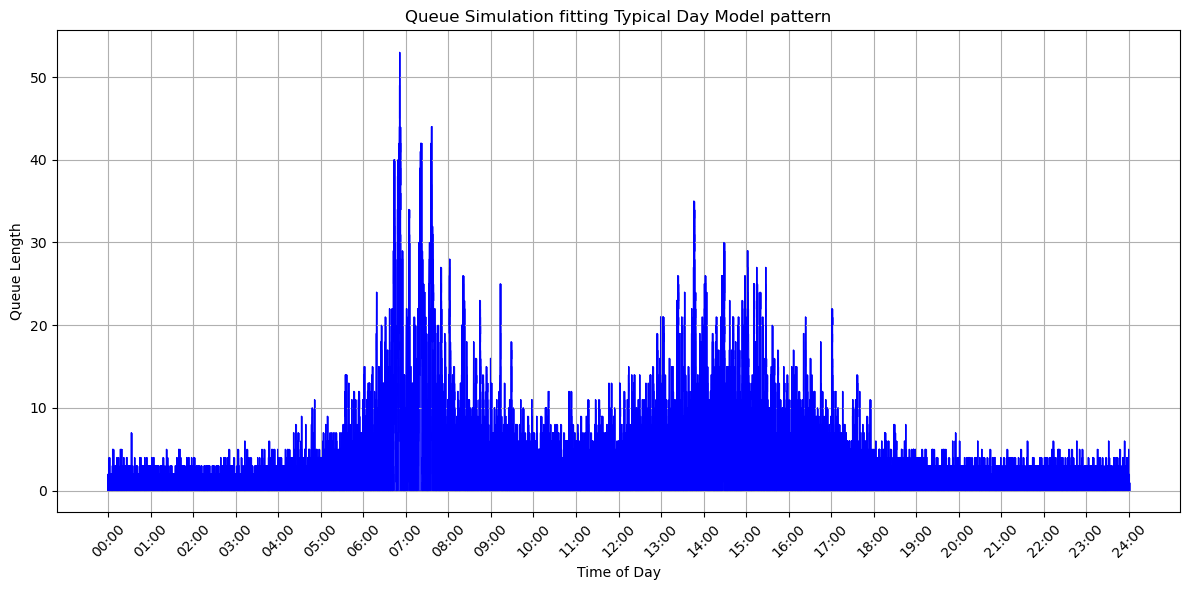


Simulation Statistics:
average_queue_length: 3.93
max_queue_length: 53.00
total_arrivals: 113986.00
total_departures: 113985.00
rejected_arrivals: 0.00
average_waiting_time: 0.03
max_waiting_time: 0.40
min_waiting_time: 0.00


In [155]:
def arrival_rate(t, base_rate=40, peaks=None):
    """
    Calculates arrival rate at time t based on GMM components
    
    Parameters:
    t (float): Time in minutes from midnight
    base_rate (float): Background traffic flow rate (cars per minute)
    peaks (list): List of dictionaries for each peak period
    
    Returns:
    rate (float): Arrival rate at time t
    """
    if peaks is None:
        peaks = [
            # Morning peak (around 7:00)
            {"amplitude": 90, "time": 420, "width": 90},  # 7 AM
            
            # Mid-morning peak (around 11:00)
            {"amplitude": 30, "time": 660, "width": 120},  # 11 AM
            
            # Afternoon peak (around 15:00)
            {"amplitude": 80, "time": 900, "width": 120},  # 3 PM
        ]
    
    # Base rate varies by time of day to match Component 2 (night/early morning)
    if 0 <= t < 360:  # Midnight to 6 AM
        base_rate = 35  # Lower base rate for night hours
    elif 360 <= t < 720:  # 6 AM to 12 PM
        base_rate = 45  # Higher base rate for morning
    elif 720 <= t < 1080:  # 12 PM to 6 PM
        base_rate = 50  # Peak base rate for afternoon
    else:  # 6 PM to midnight
        base_rate = 40  # Moderate base rate for evening
    
    rate = base_rate
    for peak in peaks:
        A = peak["amplitude"]
        t_peak = peak["time"]
        sigma = peak["width"]
        # Gaussian peak addition
        rate += A * np.exp(-((t - t_peak)**2) / (2 * sigma**2))
    
    return rate



def service_rate(t):
    return 150  # cars per minute
    
if __name__ == "__main__":
    # Create simulation
    sim = NonStationaryMM1(
        arrival_rate_func=lambda t: arrival_rate(t),
        service_rate_func=service_rate,
        T_end=1440,  # 1440 minutes = 24 hours
        initial_queue_length=0,
        max_queue_length=100,  # Adjust as needed
        time_step=1  # 1-minute time steps
    )

    # Run simulation
    sim.run_simulation()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.fill_between(sim.time_history, sim.queue_length_history, 
                 color='blue', 
                 alpha=0.8)  # fill with transparency
    plt.plot(sim.time_history, sim.queue_length_history, 
         color='blue', 
         linewidth=0.8)
    
    # Convert minutes to time of day labels
    def minutes_to_timestring(minutes):
        hours = int(minutes // 60)
        mins = int(minutes % 60)
        return f"{hours:02d}:{mins:02d}"

    # Set x-axis ticks every hour (60 minutes)
    xticks = np.arange(0, 1441, 60)  # 0 to 1440 in steps of 60
    xtick_labels = [minutes_to_timestring(x) for x in xticks]
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel('Time of Day')
    plt.ylabel('Queue Length')
    plt.title('Queue Simulation fitting Typical Day Model pattern')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/queue_typical.png')
    plt.show()

    # Print statistics
    stats = sim.get_statistics()
    print("\nSimulation Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")

### Staggered school start times 

In [157]:
def arrival_rate(t, base_rate=40, peaks=None):
    """
    Calculates arrival rate at time t based on GMM components
    
    Parameters:
    t (float): Time in minutes from midnight
    base_rate (float): Background traffic flow rate (cars per minute)
    peaks (list): List of dictionaries for each peak period
    
    Returns:
    rate (float): Arrival rate at time t
    """
    if peaks is None:
        peaks = [
            # MORNING PEAK  1 (around 5:00)
            {"amplitude": 45, "time": 300, "width": 90},  # 5 AM
            
            # MORNING PEAK 2 (around 8:00)
            {"amplitude": 45, "time": 480, "width": 90},  # 7 AM

            # Mid-morning peak (around 11:00)
            {"amplitude": 42, "time": 660, "width": 120},  # 11 AM
            

            # AFTERNOON PEAK 1 (around 13:00)
            {"amplitude": 40, "time": 780, "width": 120},  # 1 PM

            # AFTERNOON PEAK 2 (around 16:00)
            {"amplitude": 40, "time": 960, "width": 120},  # 4 PM
        ]
    
    
    rate = base_rate
    for peak in peaks:
        A = peak["amplitude"]
        t_peak = peak["time"]
        sigma = peak["width"]
        #normal dist peak
        rate += A * np.exp(-((t - t_peak)**2) / (2 * sigma**2))
    
    return rate



def service_rate(t):
    return 150  # cars per minute
    
if __name__ == "__main__":
    # Create simulation
    sim = NonStationaryMM1(
        arrival_rate_func=lambda t: arrival_rate(t),
        service_rate_func=service_rate,
        T_end=1440,  # 1440 minutes = 24 hours
        initial_queue_length=0,
        max_queue_length=100,  # Adjust as needed
        time_step=1  # 1-minute time steps
    )

    # Run simulation
    sim.run_simulation()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.fill_between(sim.time_history, sim.queue_length_history, 
                 color='blue', 
                 alpha=0.8)  # fill with transparency
    plt.plot(sim.time_history, sim.queue_length_history, 
         color='blue', 
         linewidth=0.8)
         
    # Convert minutes to time of day labels
    def minutes_to_timestring(minutes):
        hours = int(minutes // 60)
        mins = int(minutes % 60)
        return f"{hours:02d}:{mins:02d}"

    # Set x-axis ticks every hour (60 minutes)
    xticks = np.arange(0, 1441, 60)  # 0 to 1440 in steps of 60
    xtick_labels = [minutes_to_timestring(x) for x in xticks]
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel('Time of Day')
    plt.ylabel('Queue Length')
    plt.title('Queue Simulation with Adjusted Policies')
    plt.grid(True)
    plt.tight_layout() 
    plt.savefig('data/queue_policy.png')
    plt.show()

    # Print statistics
    stats = sim.get_statistics()
    print("\nSimulation Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")